In [1]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, roc_curve

import numpy as np
import pandas as pd
import seaborn

# Variables to call
otuinfile = 'dgerver_cd_otu.txt'
mapfile = 'mapfile_dgerver.txt'
# Column name from mapfile for disease
dx = 'gastrointest_disord'

# Data read
data = pd.read_table(otuinfile,sep='\t',index_col=0,skiprows=1)
metadata = pd.read_table(mapfile,sep='\t',index_col=0)
otutab_trans = data.transpose()
merge = pd.concat([otutab_trans, metadata[dx]], axis=1,join='inner')



X = merge.drop([dx],axis=1)
y = merge[dx]

/Users/alifaruqi/Desktop/Programming/Deep-Learning/github_repo/yvonne-papers/Inouye-data/test_roc_curve_data/scikit-learn/sklearn/cross_validation.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
//anaconda/envs/inouye_lab/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
#list(metadata.columns.values)
#metadata['body_site'].unique()
# http://stackoverflow.com/questions/17071871/select-rows-from-a-dataframe-based-on-values-in-a-column-in-pandas

print (y.value_counts())

ileum_only = metadata.loc[metadata['body_site'] == 'UBERON:ileum']
rectum_only = metadata.loc[metadata['body_site'] == 'UBERON:rectum']
feces_only = metadata.loc[metadata['body_site'] == 'UBERON:feces']

ileum_rectum_stool = metadata.loc[metadata['body_site'].isin(['UBERON:feces', 'UBERON:rectum', 'UBERON:ileum'])]

print (ileum_only.shape[0])
print (rectum_only.shape[0])
print (feces_only.shape[0])
print (ileum_rectum_stool.shape[0])



641
309
283
1233
CD    731
no    336
UC    219
IC     73
Name: gastrointest_disord, dtype: int64


[Indeterminate colitis (IC) originally referred to those 10–15% of cases of inflammatory bowel disease (IBD) in which there was difficulty distinguishing between ulcerative colitis (UC) and Crohn’s disease (CD).](http://www.ncbi.nlm.nih.gov/pmc/articles/PMC1770507/)

In [2]:
## Merge CD, UC and IC in one-category called disorder, so we have binary classification
# y.unique() gives unique values of response vector
y = y.replace(to_replace=['CD','UC','IC','no'], value=['disorder','disorder','disorder','no-disorder'])
encoder = LabelEncoder()
y = pd.Series(encoder.fit_transform(y),
index=y.index, name=y.name)

**Biopsy-associated microbiome can diagnose CD**, according to a sub-heading in the study by [Gever et al.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4059512/).

*The best performance was obtained by the ileal samples (AUC = 0.85), which was closely followed by the rectal biopsies (AUC = 0.78), both with a narrow confidence interval. The stool samples, however, performed less well (AUC = 0.66) and had also a low consistency (broader confidence interval).*

In [3]:
A, P, Y, Q = train_test_split(
X, y, test_size=0.15, random_state=42)	# Can change to 0.2

clf = RandomForestClassifier(
	n_estimators=7000,random_state=0,criterion='entropy',min_samples_split=20).fit(A, Y.values.ravel())
print ("Accuracy of Random Forest Classifier: "+str(clf.score(P,Q)))

# algorithm, learning_rate_init, alpha, hidden_layer_sizes 
# and activation have impact
clf2 = MLPClassifier(algorithm='adam', alpha=0.01, max_iter=1000,
	learning_rate='adaptive', hidden_layer_sizes=(400,), 
	random_state=0, learning_rate_init=1e-2,
	activation='logistic').fit(A, Y.values.ravel())
print ("Accuracy of Multi-layer Perceptron Classifier: "+str(clf2.score(P,Q)))

clf3 = GradientBoostingClassifier(n_estimators=1000, learning_rate=1,
max_depth=10, random_state=0, min_samples_split=5).fit(A, Y.values.ravel())
print ("Accuracy of Gradient Boosting Classifier: "+str(clf3.score(P,Q)))

clf4 = SVC(kernel='rbf',C=1,
	gamma=0.001,random_state=0,probability=True).fit(A, Y.values.ravel())
print ("Accuracy of SVM: "+str(clf4.score(P,Q)))

clf5 = GaussianNB().fit(A, Y.values.ravel())
print ("Accuracy of Gaussian Naive Bayes Classifier: "+str(clf5.score(P,Q)))

Accuracy of Random Forest Classifier: 0.794117647059
Accuracy of Multi-layer Perceptron Classifier: 0.769607843137
Accuracy of Gradient Boosting Classifier: 0.799019607843
Accuracy of SVM: 0.759803921569
Accuracy of Gaussian Naive Bayes Classifier: 0.578431372549


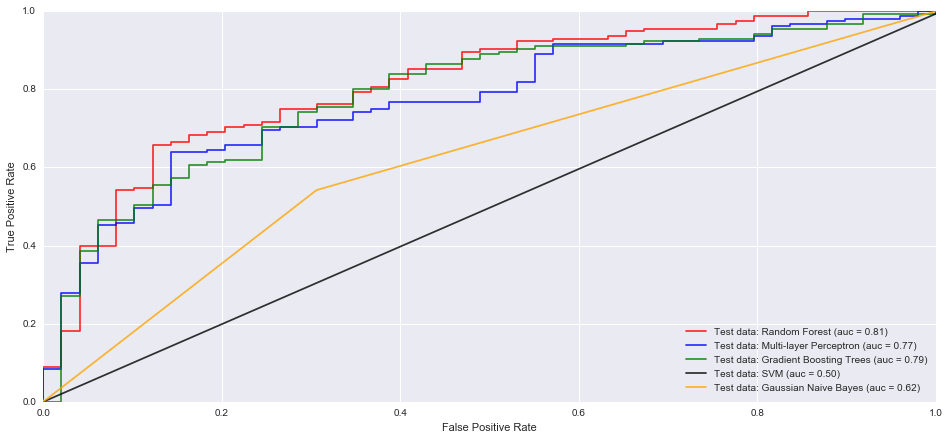

In [4]:
%matplotlib inline
# Only 2-class problem
cls = 0
# Set figure size and plot layout
figsize=(16,7)
f, ax = plt.subplots(1, 1, figsize=figsize)

params = [(clf,'red',"Random Forest"),(clf2,'blue',"Multi-layer Perceptron"),(clf3,'green',"Gradient Boosting Trees"),
         (clf4,'black',"SVM"),(clf5,'orange','Gaussian Naive Bayes')]

for x in params:
    y_true = Q[Q.argsort().index]
    y_prob = x[0].predict_proba(P.ix[Q.argsort().index,:])
    fpr, tpr, _ = roc_curve(y_true, y_prob[:, cls], pos_label=cls)
    roc_auc = roc_auc_score(y_true == cls, y_prob[:, cls])
    ax.plot(fpr, tpr, color=x[1], alpha=0.8,
    label='Test data: {} '
    '(auc = {:.2f})'.format(x[2] ,roc_auc))


ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(loc="lower right")